In [1]:
import sys, yaml
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, lfilter, freqz
from scipy.ndimage import uniform_filter1d
from scipy.optimize import minimize, Bounds
from scipy.stats import fit
from motoman_def import *

In [2]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

def dh2v(dh):
    logdh = np.log(dh)
    logv = (logdh-1.647)/-0.4619
    
    v = np.exp(logv)
    return v

def v2dh(v):
    logdh = -0.4619*np.log(v)+1.647
    
    dh = np.exp(logdh)
    return dh

def v2dh_noised(v):
    mod_noise = np.random.rand(2)-0.9
    coeff1_noised = mod_noise[0]*0.05+0.4619
    coeff2_noised = mod_noise[0]*0.5+1.647
    logdh = -coeff1_noised*np.log(v)+coeff2_noised
    
    dh = np.exp(logdh)
    return dh

def avg_by_line(job_line, flame_pos, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = np.zeros(flame_pos.shape[1])
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + flame_pos[idx,:]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = np.zeros(flame_pos.shape[1])
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty((num_segs, 3))
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i,:] = average_pos[idx, :]
         else:
              output[i,:] = [None, None, None]
    #handle missing height data

    return output

def avg_by_line_vel(job_line, cart_vel, num_segs):
    ref_idx = job_line[0]
    job_line_unique = [ref_idx]
    idx = 0
    num_points = 0
    average_pos = []
    sum = 0
    while True:
        while job_line[idx] == ref_idx:
            sum = sum + cart_vel[idx]
            num_points += 1
            idx+=1
            if idx >= len(job_line): break
        
        average_pos.append(sum/num_points)
        sum = 0
        try:
            ref_idx = job_line[idx]
            job_line_unique.append(ref_idx)
        except:
            break
        num_points = 0
    average_pos = np.array(average_pos)
    output = np.empty(num_segs)
    
    # for i, line_no in enumerate(job_line_unique):
    #     output[line_no,1:] = average_pos[i,:]
    #     output[line_no,0] = line_no
    for i in range(num_segs):
         if i in job_line_unique:
              idx = job_line_unique.index(i)
              output[i] = average_pos[idx]
         else:
              output[i] = None
    #handle missing height data

    return output
    

class speedHeightModel:
    '''
    Model relating dh to torch speed according to the equation
    ln(h) = a ln(v) + b
    '''
    def __init__(self, lam = 0.05, beta = 1, coeff_mat = [-0.4619, 1.647]):
        # Beta == 1 for non-exponentail updates
        self.coeff_mat = np.array(coeff_mat)
        self.lam = lam
        self.P = np.diag(np.ones(self.coeff_mat.shape[0])*self.lam)
        self.beta = beta
    
    def v2dh(self, v):
        logdh = self.coeff_mat[0]*np.log(v)+self.coeff_mat[1]
    
        dh = np.exp(logdh)
        return dh
    
    def dh2v(self, dh):
        logdh = np.log(dh)
        logv = (logdh-self.coeff_mat[1])/self.coeff_mat[0]
        
        v = np.exp(logv)
        return v
    
    def model_update(self, vels, dhs, weight):
        # Updates the model with new height-torchspeed data
        ln_vels = np.log(np.array(vels))
        ln_dhs = np.log(np.array(dhs))

        # check for nan values in ln(dhs)
        idxs = np.argwhere(np.isnan(ln_dhs))
        ln_dhs = np.delete(ln_dhs, idxs)
        ln_vels = np.delete(ln_vels, idxs)

        # Pseudo-inverse to calculate least squares fit based on new data
        x_mat = np.vstack((ln_vels, np.ones_like(ln_vels)))

        updated_coeff_mat = ln_dhs@np.linalg.pinv(x_mat)
        # print(updated_coeff_mat)
        # print(self.coeff_a)
        # print(self.coeff_b)
        # Model Update
        self.coeff_mat = weight*updated_coeff_mat + (1-weight)*self.coeff_mat
        # else:
        # print(self.coeff_a)
        # print(self.coeff_b)

    def model_update_RLS(self, vels, dhs):
        # Algorithm from https://osquant.com/papers/recursive-least-squares-linear-regression/
        for idx,vel in enumerate(vels):
            x  = np.array([[np.log(np.array(vel))], [1]])
            y = np.log(dhs[idx])
            if not np.isnan(y):
                r = 1+(x.T@self.P@x)/self.beta
                k = self.P@x/(r*self.beta)
                e = y-x.T@self.coeff_mat
                self.coeff_mat = self.coeff_mat+k@e
                self.P = self.P/self.beta-k@k.T*r






In [3]:
dataset='bent_tube/'
sliced_alg='slice_ER_4043/'
data_dir='../data/'+dataset+sliced_alg

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)
with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
por = slicing_meta['point_of_rotation']
angle = slicing_meta['layer_angle']

with open(data_dir+'slicing.yml', 'r') as file:
	slicing_meta = yaml.safe_load(file)
base_thickness = slicing_meta['baselayer_thickness']

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

save_path = f'../../recorded_data/ER4043_bent_tube_2024_08_01_11_47_23/'
H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')

# Load Data

In [4]:
job_no_offset = 3
joint_angles = []
for layer in range(1,80):
    joint_angles_layer = np.loadtxt(save_path+f'layer_{layer}/weld_js_exe.csv', delimiter=',')
    joint_angles.append(joint_angles_layer)
print(joint_angles[0].shape)

(5364, 16)


In [5]:
layer_dir = []
for layer in range(1,80):
    layer_dir.append(np.loadtxt(save_path+f'layer_{layer}/start_dir.csv', delimiter=','))

In [6]:
# velocity setpoints
set_vel = []
for layer in range(1,80):
    layer_vel_profile = np.loadtxt(save_path+f'layer_{layer}/velocity_profile.csv', delimiter=',')

    if not layer_dir[layer-1]:
            layer_vel_profile = layer_vel_profile[::-1]
    set_vel.append(layer_vel_profile)

print(len(set_vel))

79


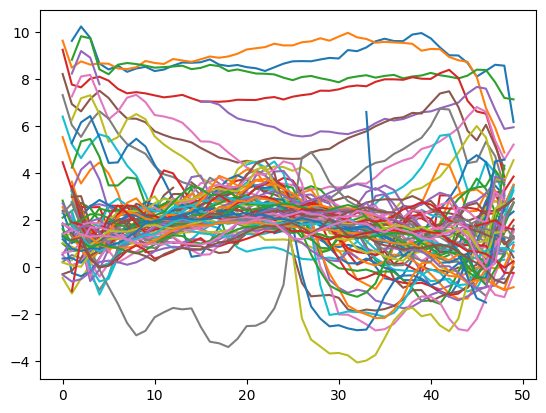

In [44]:
'''height error: rotate the flame data down to 0, and record height'''
p = H[:3, -1]
R = H[:3, :3]
height_data = []
for layer in range(1,80):
    with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
        flame_3d = pickle.load(file)
    with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
        job_no = pickle.load(file)
    job_no = [i-job_no_offset for i in job_no]
    if flame_3d.shape[0]>1: 
        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        layer_angle = angle*(layer-1)
        layer_angle=np.deg2rad(layer_angle)
        # print(flame_3d.shape)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        if not layer_dir[layer-1]:
            heights = heights[::-1]

        height_data.append(heights)
    else: height_data.append(None)

for layer in height_data:
    if not np.any(layer ==None):
        plt.plot(layer) 
plt.show()

height_data_prev = []
for layer in range(1,79):
    with open(save_path+'layer_'+ str(layer)+'/flame_3d_'+str(layer)+'_0.pkl', 'rb') as file:
        flame_3d = pickle.load(file)
    with open(save_path+'layer_'+ str(layer)+'/ir_job_no_'+str(layer)+'.pkl', 'rb') as file:
        job_no = pickle.load(file)
    job_no = [i-job_no_offset for i in job_no]
    if flame_3d.shape[0]>1: 
        for i in range(flame_3d.shape[0]):
            flame_3d[i] = R.T@flame_3d[i]
        layer_angle = angle*(layer)
        layer_angle=np.deg2rad(layer_angle)
        # print(flame_3d.shape)
        new_x, new_z = rotate((por,base_thickness), (flame_3d[:,0], flame_3d[:,2]), layer_angle)
        flame_3d[:,0] = new_x
        flame_3d[:,2] = new_z-base_thickness
        averages = avg_by_line(job_no, flame_3d, 50)
        heights = averages[:,-1]
        if not layer_dir[layer-1]:
            heights = heights[::-1]

        height_data_prev.append(heights)
    else: height_data_prev.append(np.empty_like(heights))


In [9]:
# calculate cartesian velocities at each 

time_series = []
calc_vel = []
avg_vel = []
for layer in range(1,80):
    # Job line 3 doesn't exist?
    try:
        joint_idx_start = np.where(joint_angles[layer-1][:,1]==job_no_offset)[0][0]
    except:
        joint_idx_start = np.where(joint_angles[layer-1][:,1]==job_no_offset+1)[0][0]

    joint_angles_prev = joint_angles[layer-1][joint_idx_start-1,:]
    joint_angles_layer = joint_angles[layer-1][joint_idx_start:,:]
    pose_prev=robot.fwd(joint_angles_prev[2:8]).p
    time_prev = joint_angles_prev[0]
    
    time_series_layer = []
    job_nos_layer = []
    calc_vel_layer = []
    for i in range(joint_angles_layer.shape[0]):
    # calculate instantatneous velocity
        robot1_pose = robot.fwd(joint_angles_layer[i,2:8])
        cart_dif = robot1_pose.p - pose_prev
        time_stamp = joint_angles_layer[i][0]
        time_dif = time_stamp-time_prev
        time_prev = time_stamp
        cart_vel = cart_dif/time_dif
        time_prev = time_stamp
        pose_prev = robot1_pose.p
        lin_vel = np.sqrt(cart_vel[0]**2+cart_vel[1]**2+cart_vel[2]**2)
        calc_vel_layer.append(lin_vel)
        job_nos_layer.append(joint_angles_layer[i][1])
        time_series_layer.append(time_stamp)
    job_nos_layer = [i-job_no_offset for i in job_nos_layer]
    vel_avg = avg_by_line_vel(job_nos_layer, calc_vel_layer, 50)

    if not layer_dir[layer-1]:
            vel_avg = vel_avg[::-1]
    time_series.append(time_series_layer)
    calc_vel.append(calc_vel_layer)
    avg_vel.append(vel_avg)


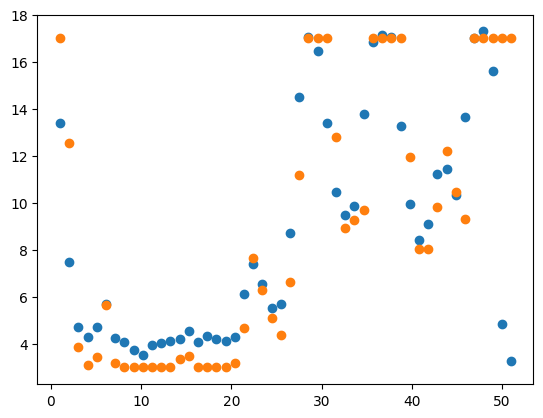

In [23]:
# Check velocities
layer = 16
plt.scatter(np.linspace(1,51,50), avg_vel[layer-1])
plt.scatter(np.linspace(1,51,50), set_vel[layer-1])

# Calculations

[4.062408829789875, 12.986628971944146]
[        nan  4.7089743   5.60567121  6.3907688   9.07194526 11.97296001
 10.13387885  7.53468794  5.76631748  5.33831194  5.01597591  4.79998457
  4.96186397  4.9725155   4.60522338  4.28376017  4.5015587   4.66709348
  4.66854169  4.58714644  4.37440687  4.30573656  4.13112823  4.16510988
  4.17962068  4.06240883  4.46106967  4.7259321   4.73350931  4.87508066
  4.75339964  5.06706195  5.09234788  6.09664643  6.73827019  6.972975
  7.0468995   6.21253006  5.11584407  4.50445187  5.54370009  6.97376572
  8.46552609  9.85227484 11.51373087 12.98662897  8.33261143  4.25790061
  5.52003599  8.62034276]
Coefficients:  [-0.29571731  1.1424663 ]


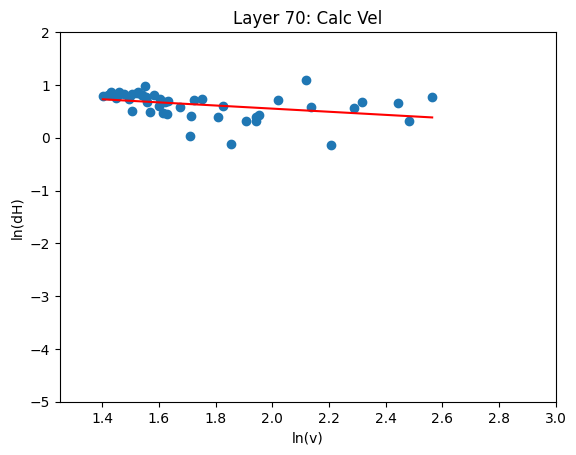

Coefficients:  [-0.32684455  1.15497407]


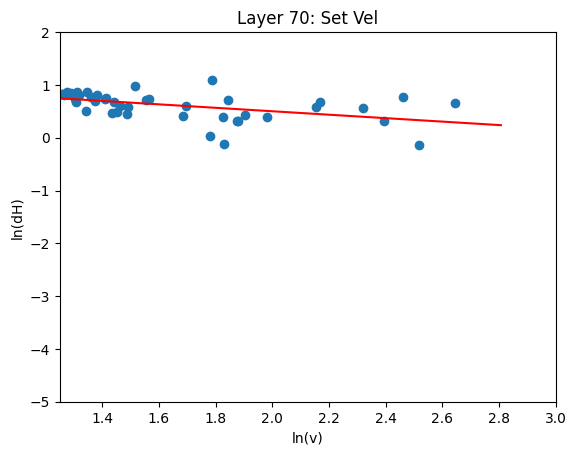

In [73]:
# Fit plots for the set velocity and measured velocity
layer = 70
dh = height_data[layer-1]-height_data_prev[layer-2]
model = speedHeightModel()
model.model_update(avg_vel[layer-1], dh, 1)
v_range = [np.nanmin(avg_vel[layer-1]), np.nanmax(avg_vel[layer-1])]
dh_fit = model.v2dh(v_range)
print(v_range)
print(avg_vel[layer-1])
print("Coefficients: ", model.coeff_mat)
fig, ax = plt.subplots()
ax.scatter(np.log(avg_vel[layer-1]),np.log(dh))
ax.plot(np.log(v_range), np.log(dh_fit), 'r')
ax.set_title(f"Layer {layer}: Calc Vel")
ax.set_ylabel("ln(dH)")
ax.set_xlabel("ln(v)")
ax.set_ylim(-5,2)
ax.set_xlim(1.25,3)
plt.show()
model.model_update(set_vel[layer-1], dh, weight=1)
v_range = [np.min(set_vel[layer-1]), np.max(set_vel[layer-1])]
dh_fit = model.v2dh(v_range)

print("Coefficients: ", model.coeff_mat)
fig, ax = plt.subplots()
ax.scatter(np.log(set_vel[layer-1]),np.log(dh))
ax.plot(np.log(v_range), np.log(dh_fit), 'r')
ax.set_title(f"Layer {layer}: Set Vel")
ax.set_ylabel("ln(dH)")
ax.set_xlabel("ln(v)")
ax.set_ylim(-5,2)
ax.set_xlim(1.25,3)
plt.show()

C:\Users\Jack\AppData\Local\Temp\ipykernel_9472\3854004776.py:165: RuntimeWarning: invalid value encountered in log
  y = np.log(dhs[idx])
C:\Users\Jack\AppData\Local\Temp\ipykernel_9472\3854004776.py:141: RuntimeWarning: invalid value encountered in log
  ln_dhs = np.log(np.array(dhs))


unsupported operand type(s) for -: 'NoneType' and 'float'
unsupported operand type(s) for -: 'NoneType' and 'float'


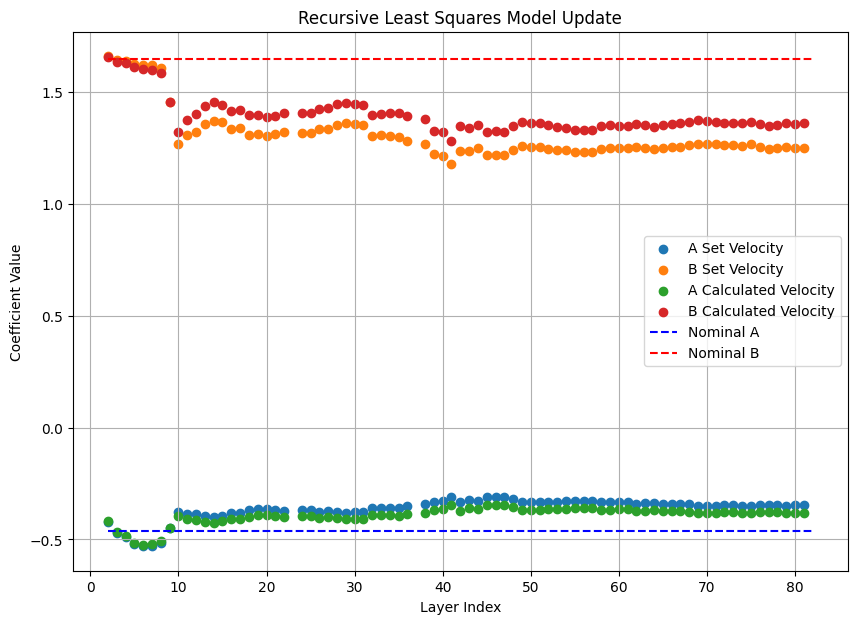

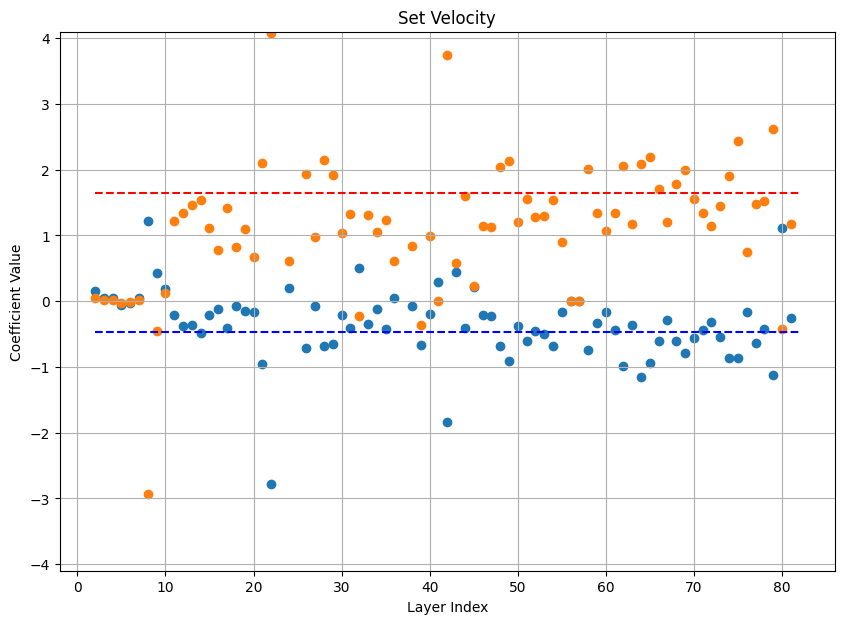

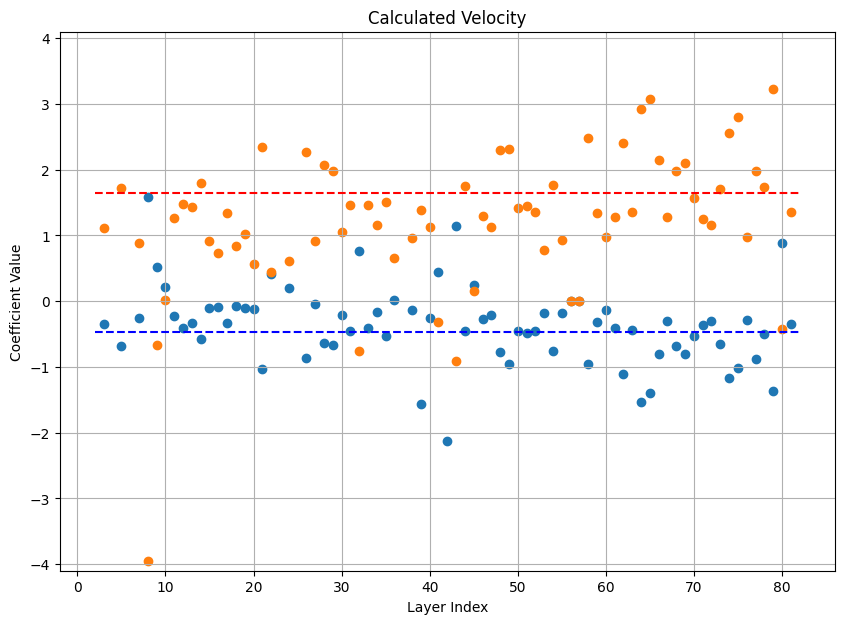

In [74]:
layer_start = 2
layer_end = 80
coeff_a = []
coeff_b = []
coeff_a_layer = []
coeff_b_layer = []
coeff_a_calc = []
coeff_b_calc = []
coeff_a_calc_layer = []
coeff_b_calc_layer = []

model_set = speedHeightModel()
model_set_layer = speedHeightModel()
model_calc = speedHeightModel()
model_calc_layer = speedHeightModel()
nom_coeff_a = model_set.coeff_mat[0]
nom_coeff_b = model_set.coeff_mat[1]
for layer in range(layer_start,layer_end):
    try:
        dh = height_data[layer-1]-height_data_prev[layer-2]
    except Exception as e:
        print(e)
        coeff_a.append(None)
        coeff_b.append(None)
        coeff_a_calc.append(None)
        coeff_b_calc.append(None)
        coeff_a_layer.append(None)
        coeff_b_layer.append(None)
        coeff_a_calc_layer.append(None)
        coeff_b_calc_layer.append(None)

    model_set.model_update_RLS(set_vel[layer-1][1:-2], dh[1:-2])
    model_calc.model_update_RLS(avg_vel[layer-1][1:-2], dh[1:-2])
    model_set_layer.model_update(set_vel[layer-1][1:-2], dh[1:-2],1)
    model_calc_layer.model_update(avg_vel[layer-1][1:-2], dh[1:-2],1)
    coeff_a.append(model_set.coeff_mat[0])
    coeff_b.append(model_set.coeff_mat[1])
    coeff_a_calc.append(model_calc.coeff_mat[0])
    coeff_b_calc.append(model_calc.coeff_mat[1])
    coeff_a_layer.append(model_set_layer.coeff_mat[0])
    coeff_b_layer.append(model_set_layer.coeff_mat[1])
    coeff_a_calc_layer.append(model_calc_layer.coeff_mat[0])
    coeff_b_calc_layer.append(model_calc_layer.coeff_mat[1])
   

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a)-1,len(coeff_a)), coeff_a)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b)-1,len(coeff_b)), coeff_b)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_calc)-1,len(coeff_a_calc)), coeff_a_calc)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_calc)-1,len(coeff_b_calc)), coeff_b_calc)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.legend(("A Set Velocity", "B Set Velocity","A Calculated Velocity", "B Calculated Velocity", "Nominal A", "Nominal B", "Average A", "Average B"))
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.title(f"Recursive Least Squares Model Update")
plt.show()

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_layer)-1,len(coeff_a_layer)), coeff_a_layer)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_layer)-1,len(coeff_b_layer)), coeff_b_layer)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.gca().set_ylim(-4.1,4.1)
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.gca().set_title("Set Velocity")
plt.show()

plt.scatter(np.linspace(layer_start,layer_start+len(coeff_a_calc_layer)-1,len(coeff_a_calc_layer)), coeff_a_calc_layer)
plt.scatter(np.linspace(layer_start,layer_start+len(coeff_b_calc_layer)-1,len(coeff_b_calc_layer)), coeff_b_calc_layer)
plt.plot([layer_start, layer_start+len(coeff_a)],[nom_coeff_a, nom_coeff_a], 'b--')
plt.plot([layer_start, layer_start+len(coeff_b)],[nom_coeff_b, nom_coeff_b], 'r--')
plt.gca().set_ylim(-4.1,4.1)
plt.gca().set_xlabel("Layer Index")
plt.gca().set_ylabel("Coefficient Value")
plt.gca().grid()
plt.gcf().set_size_inches(10,7)
plt.gca().set_title("Calculated Velocity")
plt.show()

# Simulation based on models

In [79]:
# Model Setup
def delta_v(v):
    delta_v = [v[i]-v[i+1] for i in range(len(v)-1)]
    return delta_v
def v_opt(v_next, v_prev, h_err, h_targ, lam, beta):
    return norm(h_targ+h_err-v2dh(v_next), 2)**2 + lam*norm(v_next-v_prev, 2)**2 + beta*norm(delta_v(v_next), 2)**2



noisy_coeff_a = []
noisy_coeff_b = []
for val in coeff_a_calc_layer:
    if val != None :
        noisy_coeff_a.append(val)
for val in coeff_b_calc_layer:
    if val != None :
        noisy_coeff_b.append(val)

np.random.shuffle(noisy_coeff_a)
np.random.shuffle(noisy_coeff_b)
print(np.mean(noisy_coeff_a))
print(np.mean(noisy_coeff_b))


num_layers = 80
part_len = 50 #mm
v_min = 5
max_dH = v2dh(v_min)
v_max = 15
min_dH = v2dh(v_max)
points_per_layer = 50

layer_angle = np.arcsin((max_dH-min_dH)/part_len)
rot_point = max_dH/np.tan(layer_angle)-part_len/2
print(np.rad2deg(layer_angle))
print(rot_point)
print(max_dH)
print(min_dH)
print(np.rad2deg(num_layers*layer_angle))


0.4164391213997231
-0.9429737175664132
1.1257976619508032
100.6131657840027
2.468475190539253
1.4860946104132609
90.06381295606425


Final Height Error:  13.950250651629132


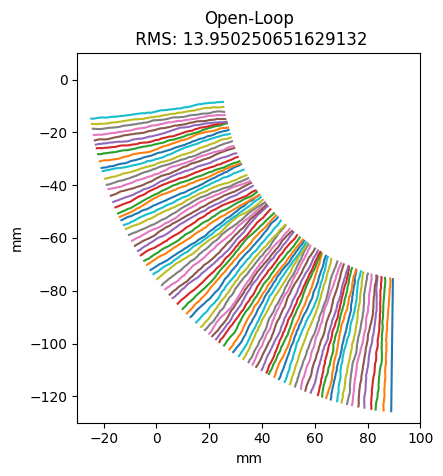

In [82]:
np.random.seed(1234)
def noisy_profile(nom_profile):
    noise = (np.random.rand(len(nom_profile))-0.5)*5
    #noise_profile = savgol_filter(noise+nom_profile, int(len(nom_profile/20)), 10, mode='interp')
    noise_profile = uniform_filter1d(noise+nom_profile, 20)
    # noise_profile = noise+nom_profile
    return noise_profile
# nominal layer plot
layers = []
x_vals = np.linspace(-part_len/2, part_len/2, points_per_layer)
height_profile = np.linspace(max_dH, min_dH, points_per_layer)
vel_nom = dh2v(height_profile)

curve_curved=np.zeros((num_layers*points_per_layer,2))
new_x, new_y = rotate((rot_point,0), (x_vals, height_profile), layer_angle)
# first layer
curve_curved[:points_per_layer, 0] = x_vals
curve_curved[:points_per_layer, 1] = v2dh_noised(vel_nom)+10
offset = 0
for i in range(1,num_layers):
    if not(coeff_a[i-offset] == None or coeff_b[i-offset] == None):
        model = speedHeightModel(coeff_mat=[coeff_a[i], coeff_b[i]])
    else:
        model = speedHeightModel(coeff_mat=model.coeff_mat)
        offset += 1
    new_x, new_y = rotate((rot_point,0), (curve_curved[:points_per_layer*i+1, 0], curve_curved[:points_per_layer*i+1,1]), layer_angle)
    curve_curved[:i*points_per_layer+1, :] = np.array([new_x, new_y]).T
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 0] = x_vals
    curve_curved[i*points_per_layer:(i+1)*points_per_layer, 1] = noisy_profile(model.v2dh(vel_nom)+curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1])
#final rotation
curve_curved[:,0], curve_curved[:,1] = rotate((rot_point,0), (curve_curved[:, 0], curve_curved[:,1]), layer_angle)
final_error = np.sqrt(np.sum(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]**2)/
                                      len(curve_curved[(i-1)*points_per_layer:i*points_per_layer, 1]))
print("Final Height Error: ", final_error)
fig,ax = plt.subplots()
for i in range(num_layers):
    ax.plot(curve_curved[i*points_per_layer:(i+1)*points_per_layer,0], curve_curved[i*points_per_layer:(i+1)*points_per_layer,1])
ax.set_aspect('equal')
ax.set_xlim(-30,100)
ax.set_ylim(-130, 10)
ax.set_title(f"Open-Loop\n RMS: {final_error}")
ax.set_xlabel("mm")
ax.set_ylabel("mm")
plt.show()